#### [ 로지스틱, KNN기반 분류 모델 - 생존자 분류 ]
- 데이터셋 : titanic.csv
- 주제 : 생존자분류
- 타겟 : Survived
- 피쳐 : 상관관계 높은 피쳐.
- 학습종류 : 지도학습 /분류
- 알고리즘 : 로지스틱, KNN 기반 분류진행

In [1]:
## 1-1
import pandas as pd
# 데이터 분석 및 전처리
import numpy as np
# 숫자처리
import matplotlib.pyplot as plt
# 데이터 시각화
from sklearn.neighbors import KNeighborsRegressor
                                #knn
from sklearn.linear_model import LinearRegression, LogisticRegression
                            ## ML 알고리즘
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
                            ## 성능평가 모듈
from sklearn.model_selection import train_test_split
                            ## 데이터셋 분리 관련 모듈
                            ## 학습/검증/테스트 
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
                            ## 정규화, 컬럼추가

from _utils import tools as ts                             

#### [1] 데이터 준비 및 확인

PassengerId	승객의 고유 ID<br>
Survived	생존 여부 (0 = 사망, 1 = 생존)<br>
Pclass	티켓 등급 (1 = 1등석, 2 = 2등석, 3 = 3등석)<br>
Name	승객의 이름<br>
Sex	성별 (male, female)<br>
Age	나이 (일부 결측값 존재)<br>
SibSp	함께 탑승한 형제자매 및 배우자의 수<br>
Parch	함께 탑승한 부모 및 자녀의 수<br>
Ticket	티켓 번호<br>
Fare	운임 요금<br>
Cabin	선실 번호 (일부 결측값 존재)<br>
Embarked 탑승한 항구

In [2]:
originDF = pd.DataFrame(pd.read_csv('../data/train.csv', index_col='PassengerId'))
originDF.info()
originDF.head()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


데이터 분석
- Name은 변별력이 없음. 
- Ticket과 Pclass간 관계, 같은 티켓을 사용한 사용자간 관계 추측.
- Cabin -> 결측값 다수. 티켓 및 fare로 추측하기.

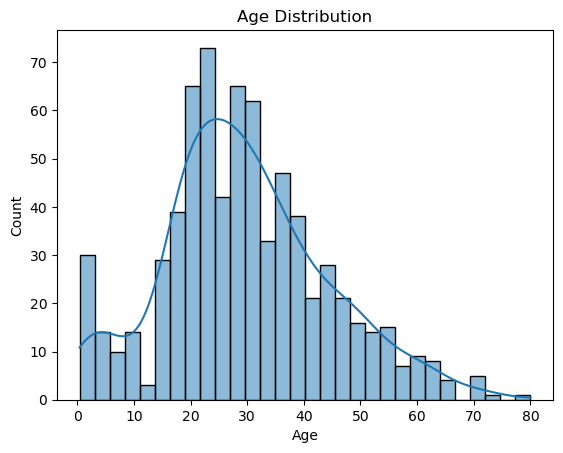

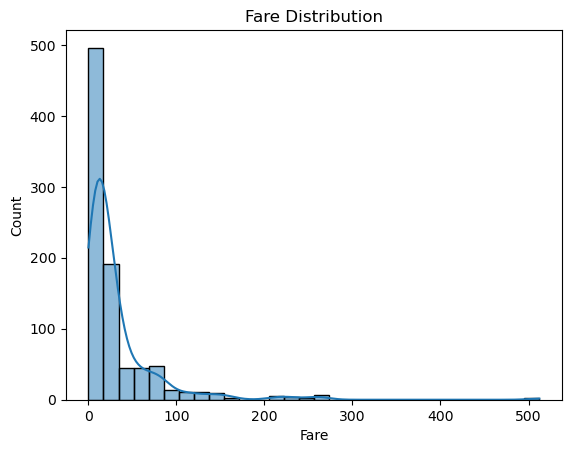

In [3]:
import seaborn as sns

# Age 분포 확인
sns.histplot(originDF['Age'], kde=True, bins=30)
plt.title("Age Distribution")
plt.show()

# Fare 분포 확인
sns.histplot(originDF['Fare'], kde=True, bins=30)
plt.title("Fare Distribution")
plt.show()


In [4]:
originDF = originDF.drop(index=originDF[originDF['Fare']>300].index)

In [5]:
originDF.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       686
Embarked      2
dtype: int64

In [6]:
titles = [
    "Mr.", "Mrs.", "Miss.", "Master.", "Dr.", 
    "Rev.", "Col.", "Major.", "Sir.", "Lady.", 
    "Countess.", "Ms.", "Mlle.", "Mme.", "Dr. Mrs."
]
for i in titles:
    if originDF[(originDF['Name'].str.contains(i) & (originDF['Age'].isna()))].index.any():
        a = originDF[(originDF['Name'].str.contains(i))]['Age'].mean()
        nullindex = originDF[(originDF['Name'].str.contains(i)) & (originDF['Age'].isna())]['Age'].index
        print(i, a, len(nullindex))
        originDF.loc[nullindex,'Age'] = originDF.loc[nullindex,'Age'].fillna(a)

Mr. 33.1090373280943 136
Miss. 21.682758620689654 36
Master. 4.574166666666667 4
Dr. 37.85363984674329 1


In [7]:
originDF.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       686
Embarked      2
dtype: int64

In [8]:
newDF = originDF.drop(columns=['Name','SibSp', 'Parch', 'Ticket', 'Embarked'])
newDF

,Survived,Pclass,Sex,Age,Fare,Cabin
PassengerId,,,,,,
1,0,3,male,22.000000,7.2500,NaN
2,1,1,female,38.000000,71.2833,C85
3,1,3,female,26.000000,7.9250,NaN
4,1,1,female,35.000000,53.1000,C123
5,0,3,male,35.000000,8.0500,NaN
...,...,...,...,...,...,...
887,0,2,male,27.000000,13.0000,NaN
888,1,1,female,19.000000,30.0000,B42
889,0,3,female,21.682759,23.4500,NaN


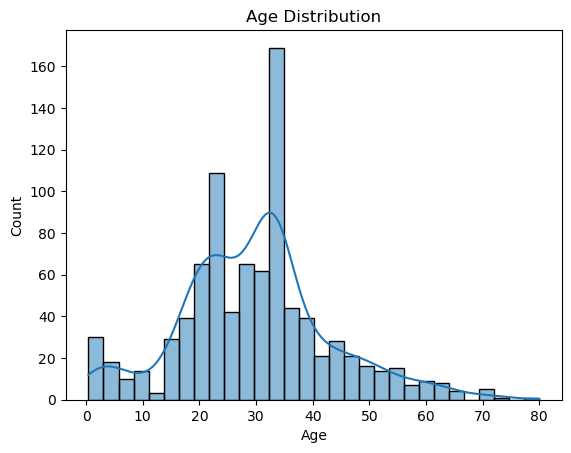

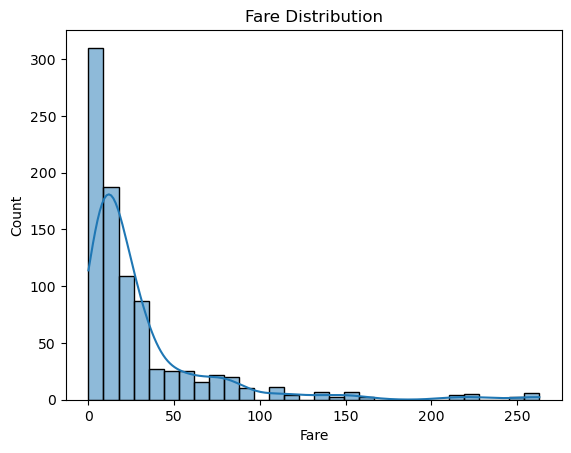

In [9]:
import seaborn as sns

# Age 분포 확인
sns.histplot(newDF['Age'], kde=True, bins=30)
plt.title("Age Distribution")
plt.show()

# Fare 분포 확인
sns.histplot(newDF['Fare'], kde=True, bins=30)
plt.title("Fare Distribution")
plt.show()


In [10]:
originDF[originDF['Age'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,


Cabin 컬럼은 빈값이 너무 많아 채우더라도 진실성이 의심됨. 폐기
label 필요 컬럼
Sex, Age, Fare, Embarked

In [11]:
# originDF.to_csv('titanic_prepro.csv', encoding='utf-8')

In [12]:
originDF.drop(columns='Cabin',inplace=True)

In [13]:
## male = 0 , female = 1
originDF['Sex'] = originDF['Sex'].map({'male': 1, 'female':0})
originDF['Sex'] = originDF['Sex'].astype('int')
originDF['Sex'].value_counts()

Sex
1    575
0    313
Name: count, dtype: int64

In [14]:
newDF = originDF.drop(columns=['Name','SibSp', 'Parch', 'Ticket', 'Embarked'])
newDF

,Survived,Pclass,Sex,Age,Fare
PassengerId,,,,,
1,0,3,1,22.000000,7.2500
2,1,1,0,38.000000,71.2833
3,1,3,0,26.000000,7.9250
4,1,1,0,35.000000,53.1000
5,0,3,1,35.000000,8.0500
...,...,...,...,...,...
887,0,2,1,27.000000,13.0000
888,1,1,0,19.000000,30.0000
889,0,3,0,21.682759,23.4500


In [15]:
newDF['Fare'].max()

263.0

In [16]:
# ts.plot_corr(newDF, newDF.columns[[1,2,3,4]], newDF.columns[0])

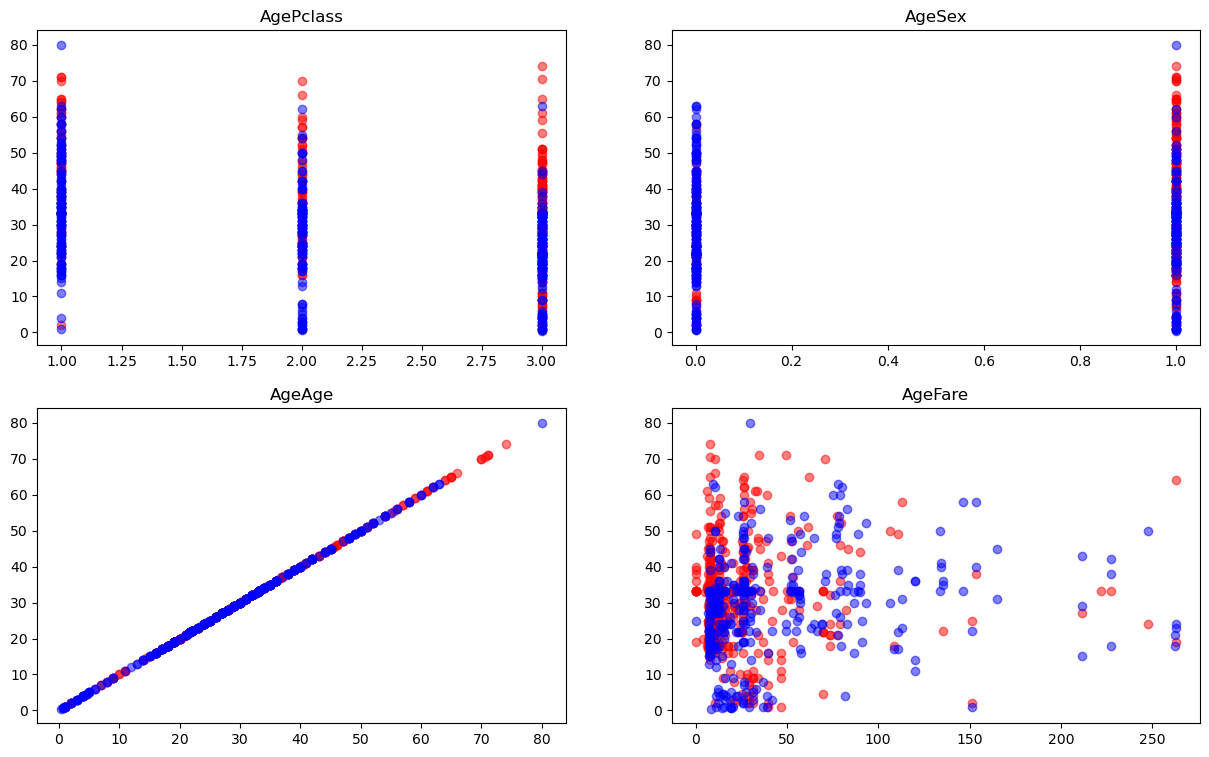

In [17]:
# [1, 3, 4, 5, 6, 8, 12]
fig, axe = plt.subplots(2,2, figsize=(15,9))
axe = axe.flatten()
target = 'Age'
colnum = [1, 2, 3, 4]

dead = newDF[newDF['Survived']==0]
live  = newDF[newDF['Survived']==1]
# print(newDF.columns[colnum])
# print(dead[target])
for ax, i in zip(axe,newDF.columns[colnum]):
    ax.plot(dead[i], dead[target], 'or', alpha=0.5)
    ax.plot(live[i], live[target], 'ob', alpha=0.5)
    ax.set_title(target+i)

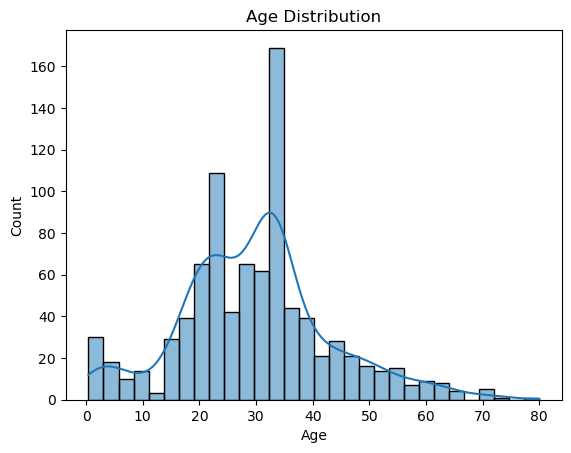

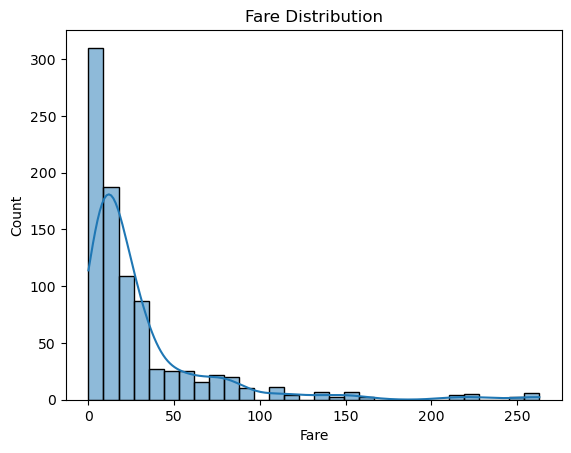

In [18]:
import seaborn as sns

# Age 분포 확인
sns.histplot(newDF['Age'], kde=True, bins=30)
plt.title("Age Distribution")
plt.show()

# Fare 분포 확인
sns.histplot(newDF['Fare'], kde=True, bins=30)
plt.title("Fare Distribution")
plt.show()


In [19]:
newDF.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
Fare        0
dtype: int64

In [20]:
featureDF = newDF[newDF.columns[[1,2,3,4]]]
classDF = newDF['Survived']
print(f'featureDF : {featureDF.shape}  classDF : {classDF.shape}')

featureDF : (888, 4)  classDF : (888,)


In [21]:
## - 회귀가 아니고 분류 시행시에는
## 훈련용이랑 테스트용에 동일한 비율로 
## 타겟이 배분되어야 한다.
## setosa : versi = 5:5
#  ==> stratify 매개변수: 타겟 데이터셋의 클래스/라벨 비율에 맞게 학습용/테스트용 분리.
# pytorch엔 없음.

train_X, test_X, train_y, test_y = train_test_split(featureDF, classDF,
                                                    random_state=100,
                                                    test_size=0.3,
                                                    stratify=classDF)
print(f"train_X => {train_X.ndim}D {train_X.shape} / test_X => {test_X.ndim}D, {test_X.shape}")
print(f"train_y => {train_y.ndim}D {train_y.shape}, / test_y => {test_y.ndim}D, {test_y.shape}")
    

train_X => 2D (621, 4) / test_X => 2D, (267, 4)
train_y => 1D (621,), / test_y => 1D, (267,)


In [22]:
from sklearn.neighbors import KNeighborsClassifier
# 학습 진행 ==> 훈련용 데이터 진행 fit(2D, 1D)
knnClassifer = KNeighborsClassifier()
knnClassifer.fit(train_X, train_y)

KNeighborsClassifier()

In [23]:
# 분류모델 성능 체크 ==> 정확도 accuracy 가 성능체크로 사용됨
#train_X, test_X, train_y, test_y

score_test = knnClassifer.score(test_X, test_y)
score_train = knnClassifer.score(train_X, train_y)
score_train, score_test

(0.785829307568438, 0.6591760299625468)

In [24]:
## 각 컬럼 정규화.

In [25]:
train_X.head()

,Pclass,Sex,Age,Fare
PassengerId,,,,
220,2,1,30.000000,10.5000
43,3,1,33.109037,7.8958
785,3,1,25.000000,7.0500
725,1,1,27.000000,53.1000
155,3,1,33.109037,7.3125


In [68]:
featureDF = newDF[newDF.columns[[1,2,3,4]]]
classDF = newDF['Survived']
print(f'featureDF : {featureDF.shape}  classDF : {classDF.shape}')

train_X, test_X, train_y, test_y = train_test_split(featureDF, classDF,
                                                    random_state=100,
                                                    test_size=0.3,
                                                    stratify=classDF)
print(f"train_X => {train_X.ndim}D {train_X.shape} / test_X => {test_X.ndim}D, {test_X.shape}")
print(f"train_y => {train_y.ndim}D {train_y.shape}, / test_y => {test_y.ndim}D, {test_y.shape}")
    

featureDF : (888, 4)  classDF : (888,)
train_X => 2D (621, 4) / test_X => 2D, (267, 4)
train_y => 1D (621,), / test_y => 1D, (267,)


In [69]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
sScaler = StandardScaler()
sScaler.fit(train_X[['Age']])
train_X['Age'] = sScaler.transform(train_X[['Age']])

rScaler = RobustScaler()
rScaler.fit(train_X[['Fare']])
train_X['Fare'] = rScaler.transform(train_X[['Fare']])



In [70]:
knnClassifer = KNeighborsClassifier(n_neighbors=5)
knnClassifer.fit(train_X, train_y)

score_test1 = knnClassifer.score(test_X, test_y)
score_test2 = knnClassifer.score(train_X, train_y)
score_test2, score_test1

(0.8631239935587761, 0.6404494382022472)

[6] 성능지표 평가<hr>


In [71]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report, f1_score


In [72]:
## 예측값 계산
pre_ = knnClassifer.predict(test_X)
precision = precision_score(test_y, pre_)
recall = recall_score(test_y,pre_)
f1 = f1_score(test_y,pre_)

print(precision, recall, f1)

0.5197368421052632 0.7745098039215687 0.6220472440944882


In [73]:
## 분류성능평가 보고서
# classification_report(test_y, pre_,output_dict=True)
print(classification_report(test_y, pre_))

              precision    recall  f1-score   support

           0       0.80      0.56      0.66       165
           1       0.52      0.77      0.62       102

    accuracy                           0.64       267
   macro avg       0.66      0.67      0.64       267
weighted avg       0.69      0.64      0.64       267



In [74]:
confusion_matrix(test_y,pre_)

array([[92, 73],
       [23, 79]])

[7] 예측 및 시각화 <hr>

In [75]:
train_X

,Pclass,Sex,Age,Fare
PassengerId,,,,
220,2,1,0.025264,-0.169133
43,3,1,0.258688,-0.280523
785,3,1,-0.350133,-0.316700
725,1,1,-0.199975,1.652999
155,3,1,0.258688,-0.305472
...,...,...,...,...
529,3,1,0.700978,-0.279274
31,1,1,0.776058,0.567453
874,3,1,1.301614,-0.233293


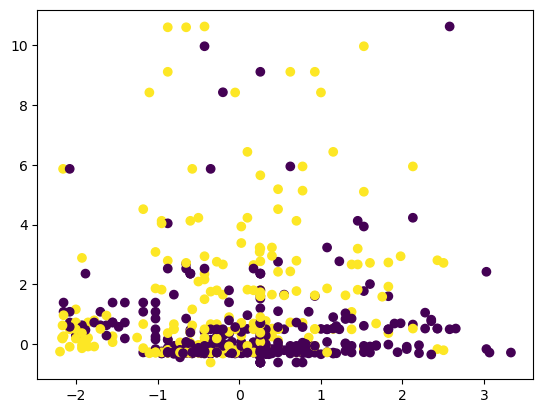

In [76]:
# 0 - pclass / 1 - sex / 2 - AgeLabel / 3 - FareLabel
# plt.scatter(train_X.loc[:,'Pclass'],train_X.loc[:,'Sex'], c=train_y)
plt.scatter(train_X.loc[:,'Age'],train_X.loc[:,'Fare'], c=train_y)
plt.show()

In [77]:
new_data = np.array([[ 3, 1, -1.939304,	0.735302]])

## 예측하기 스칼라 반환-> 0차원. item()메소드로 값 추출가능.
pre_new_data = knnClassifer.predict(new_data)
# knnClassifer.classes_

# labelEn.classes_[pre_new_data].item()
pre_new_data

c:\Users\kdt\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([0])

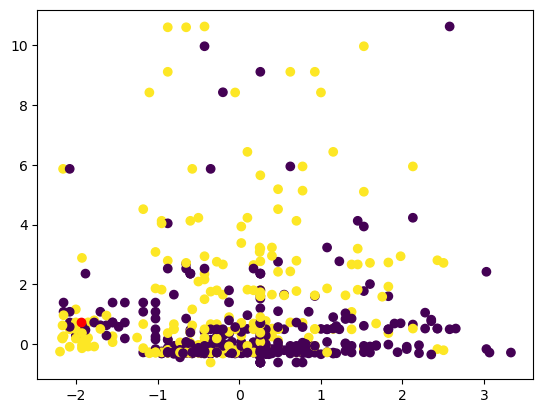

In [78]:
# 0 - pclass / 1 - sex / 2 - AgeLabel / 3 - FareLabel
# new_data = np.array([[ 3, 1, -1.939304,	0.735302]])
# plt.scatter(train_X.loc[:,'Pclass'],train_X.loc[:,'Sex'], c=train_y)
plt.scatter(train_X.loc[:,'Age'],train_X.loc[:,'Fare'], c=train_y)
plt.scatter(new_data[0,2], new_data[0,3], c='r')

plt.show()

In [79]:
distance, neighborIdx = knnClassifer.kneighbors(new_data)
neighborIdx.reshape(-1)
neighborIdx[0].tolist()

c:\Users\kdt\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


[393, 323, 448, 167, 413]

In [38]:
train_X.iloc[neighborIdx[0],2]

PassengerId
262   -2.002567
64    -1.926557
17    -2.078577
177   -1.882915
825   -2.078577
Name: Age, dtype: float64

In [ ]:
train_X.iloc[neighborIdx[0],2]

PassengerId
262   -2.002567
64    -1.926557
17    -2.078577
177   -1.882915
825   -2.078577
Name: Age, dtype: float64

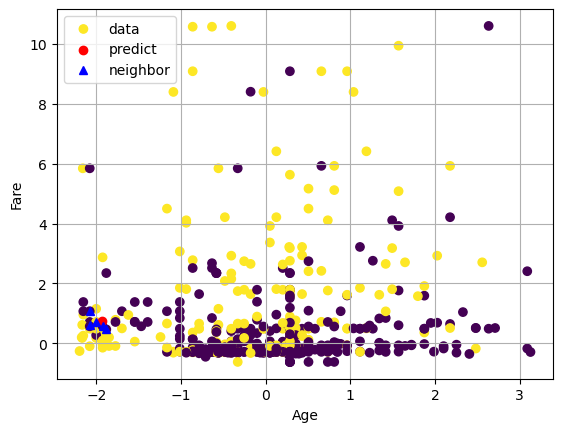

In [39]:
# 0 - pclass / 1 - sex / 2 - AgeLabel / 3 - FareLabel
# new_data = np.array([[ 3, 1, -1.939304,	0.735302]])
# plt.scatter(train_X.loc[:,'Pclass'],train_X.loc[:,'Sex'], c=train_y)
plt.scatter(train_X.loc[:,'Age'],train_X.loc[:,'Fare'], c=train_y, label = 'data')
plt.scatter(new_data[0,2], new_data[0,3], c='r', label= 'predict')
plt.plot(train_X.iloc[neighborIdx[0],2], train_X.iloc[neighborIdx[0],3], 'b^', label='neighbor')

plt.xlabel('Age');plt.ylabel('Fare')
plt.legend()
plt.grid()
plt.show()

결과 
- 정규화 전 score
    - (0.7845070422535211, 0.6797752808988764)

- 정규화 후 score
    - (0.8676056338028169, 0.7696629213483146)

- 정규화 후 교차검증
    - (0.856338028169014, 0.8089887640449438)

### 교차 검증

In [40]:
from sklearn.model_selection import cross_validate
result2= cross_validate(knnClassifer, train_X, train_y, 
                        return_estimator=True, 
                        return_train_score=True)
result2

{'fit_time': array([0.        , 0.00551963, 0.00461626, 0.        , 0.        ]),
 'score_time': array([0.01488614, 0.0020535 , 0.        , 0.        , 0.        ]),
 'estimator': [KNeighborsClassifier(),
  KNeighborsClassifier(),
  KNeighborsClassifier(),
  KNeighborsClassifier(),
  KNeighborsClassifier()],
 'test_score': array([0.80373832, 0.85046729, 0.78301887, 0.83018868, 0.81132075]),
 'train_score': array([0.85882353, 0.85411765, 0.87323944, 0.84976526, 0.8685446 ])}

In [41]:
best_estimator=result2['estimator'][1]
best_estimator

KNeighborsClassifier()

In [42]:
train_X.head()

,Pclass,Sex,Age,Fare
PassengerId,,,,
701,1,0,-0.862419,9.080358
493,1,1,1.949944,0.682915
839,3,1,0.201718,1.790888
525,3,1,0.286016,-0.308914
38,3,1,-0.634390,-0.273931


In [43]:
score_test1 = best_estimator.score(test_X, test_y)
score_test2 = best_estimator.score(train_X, train_y)
score_test2, score_test1

(0.8533834586466166, 0.601123595505618)

In [51]:
# 3	1	0.393277	-0.279952
new_data = pd.DataFrame([[3,1,0.393277,-0.279952]], columns=featureDF.columns)
best_estimator.predict(new_data)
best_estimator.predict_proba(new_data)

array([[1., 0.]])

In [45]:
##-- kfold해보기
from _utils.RegressionModule import RegressionModule as rm



In [46]:
featureDF.head()

,Pclass,Sex,Age,Fare
PassengerId,,,,
1,3,1,22.0,7.2500
2,1,0,38.0,71.2833
3,3,0,26.0,7.9250
4,1,0,35.0,53.1000
5,3,1,35.0,8.0500


In [47]:
featureDF = newDF[newDF.columns[[1,2,3,4]]]
classDF = newDF['Survived']
print(f'featureDF : {featureDF.shape}  classDF : {classDF.shape}')


featureDF : (888, 4)  classDF : (888,)


In [48]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

kfold= KFold(n_splits=5)
for train_index, test_index in kfold.split(featureDF):
    print((train_index[0]), (test_index[0]))

178 0
0 178
0 356
0 534
0 711


In [49]:
accuracies = []
for _ in range(10):
    # 데이터를 훈련 세트와 검증 세트로 나누기
    X_train, X_test, y_train, y_test = train_test_split(featureDF, classDF, test_size=0.2, stratify=classDF)
    
    # 모델 정의
    model = KNeighborsClassifier()
    
    # 모델 훈련
    model.fit(X_train, y_train)
    
    # 모델 예측 및 평가
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

In [50]:
sum(accuracies)/10

0.7061797752808989